# Bioinformática en laboratorio — Sesión 05 (parte 1)  
## Biopython: Árboles filogenéticos

**Autores:** Raúl Mendoza y Adrián Ojeda  
**Asignatura:** Bioinformática (ULPGC)

En esta libreta hacemos **los dos ejercicios** de la sesión:

- **Ejercicio 1:** Leer un árbol filogenético en formato **Newick** con *N* especies y sacar información (nodos, terminales, longitudes de ramas, clados, etc.).  
- **Ejercicio 2:** Modificar el árbol (nombres, longitudes y colores) y volver a visualizarlo.

> Nota: El enunciado de los ejercicios aparece al final del material de la sesión. fileciteturn0file0



---
## 0) Preparación del entorno

En clase solemos trabajar con **Biopython**, concretamente con el módulo `Bio.Phylo`, que permite:

- leer árboles en formatos como **Newick**,
- recorrer nodos y clados,
- calcular medidas básicas,
- y dibujarlos (usando `matplotlib`).

Si estás en un entorno donde Biopython no está instalado, descomenta el `pip install`.


In [21]:

# Si hace falta (por ejemplo en un entorno limpio), descomenta:
# !pip install biopython matplotlib

from Bio import Phylo
from io import StringIO
import matplotlib.pyplot as plt



---
## 1) Cargar un árbol en formato Newick

En el material se comenta el formato **Newick**: es básicamente una forma compacta de representar el árbol usando paréntesis, comas y un `;` final. fileciteturn0file0

Como no siempre tenemos un fichero `.dnd` a mano, aquí lo hacemos de dos maneras:

1) **Opción A (rápida):** definir un Newick en una cadena de texto.  
2) **Opción B (fichero):** si tú tienes un `simple.dnd` o cualquier `.nwk`, puedes poner su ruta y leerlo.

Vamos a usar la opción A para que el notebook sea reproducible.


In [22]:

# Opción A: árbol de ejemplo en Newick (N=6 terminales)
newick_str = "((Canis_lupus:0.10,Felis_catus:0.12):0.20,(Mus_musculus:0.25,(Gallus_gallus:0.30,Drosophila_melanogaster:0.40):0.15):0.10,Homo_sapiens:0.35);"

tree = Phylo.read(StringIO(newick_str), "newick")
tree


Tree(rooted=False, weight=1.0)

<Figure size 1000x400 with 0 Axes>

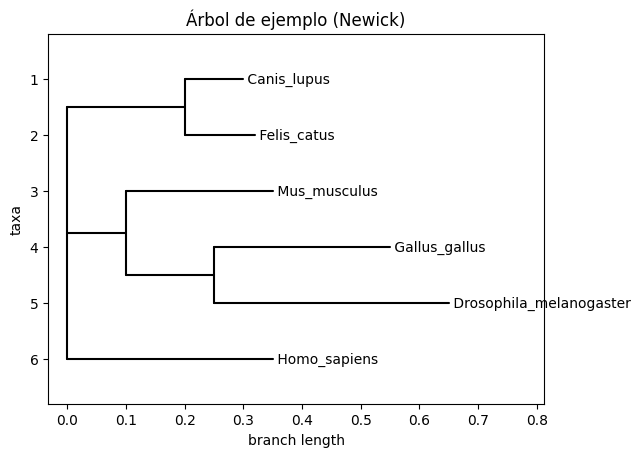

In [23]:

# Visualización básica del árbol
plt.figure(figsize=(10, 4))
Phylo.draw(tree, do_show=False)
plt.title("Árbol de ejemplo (Newick)")
plt.show()



---
# Ejercicio 1  
## Leer un árbol Newick y obtener información de nodos, ramas y clados

En el enunciado se pide, por ejemplo:  
- número de nodos,  
- número de terminales,  
- nombre de cada terminal,  
- longitud de cada rama,  
- clado más común (interpretación), etc. fileciteturn0file0

**Cómo lo hacemos:**  
- En Biopython, un árbol se compone de **clados** (`Clade`).  
- Los extremos (hojas) se llaman **terminales**.  
- Cada clado puede tener `name` y `branch_length`.  
- Para recorrer el árbol usamos `tree.find_clades()` o `tree.get_terminals()`.


In [24]:

from collections import Counter

# 1) Terminales (hojas)
terminals = tree.get_terminals()
terminal_names = [t.name for t in terminals]

# 2) Todos los clados (incluye internos y terminales)
all_clades = list(tree.find_clades())

# 3) Nodos internos = clados que NO son terminales
internal_nodes = [c for c in all_clades if c not in terminals]

# 4) Longitudes de ramas (algunas pueden venir como None si no están en el Newick)
branch_lengths = [(c.name, c.branch_length) for c in all_clades]

print("=== Resumen básico ===")
print(f"Número total de clados (nodos incluyendo hojas): {len(all_clades)}")
print(f"Número de nodos internos: {len(internal_nodes)}")
print(f"Número de terminales (hojas): {len(terminals)}")
print()
print("Terminales:")
for name in terminal_names:
    print(" -", name)


=== Resumen básico ===
Número total de clados (nodos incluyendo hojas): 10
Número de nodos internos: 4
Número de terminales (hojas): 6

Terminales:
 - Canis_lupus
 - Felis_catus
 - Mus_musculus
 - Gallus_gallus
 - Drosophila_melanogaster
 - Homo_sapiens



### Longitudes de rama

La longitud (`branch_length`) suele representar **distancia genética** o **cantidad de cambio evolutivo** (cuando estamos ante un filograma). En nuestro ejemplo, todas las hojas tienen longitud, y algunos nodos internos también.

Vamos a listar longitudes y, por si hay `None`, las tratamos con cuidado.


In [25]:

print("=== Longitudes de rama por clado ===")
for clade in all_clades:
    label = clade.name if clade.name is not None else "(interno sin nombre)"
    bl = clade.branch_length
    print(f"{label:30s} -> {bl}")


=== Longitudes de rama por clado ===
(interno sin nombre)           -> None
(interno sin nombre)           -> 0.2
Canis_lupus                    -> 0.1
Felis_catus                    -> 0.12
(interno sin nombre)           -> 0.1
Mus_musculus                   -> 0.25
(interno sin nombre)           -> 0.15
Gallus_gallus                  -> 0.3
Drosophila_melanogaster        -> 0.4
Homo_sapiens                   -> 0.35



### Profundidad y distancia acumulada (idea intuitiva)

Una manera sencilla de “mirar” el árbol es calcular la **distancia desde la raíz** a cada terminal (sumando longitudes).  
Biopython tiene utilidades como `tree.depths()` que devuelven un diccionario con esa información.


In [26]:

depths = tree.depths()  # suma de longitudes desde la raíz

print("=== Distancia raíz -> terminal ===")
for t in terminals:
    print(f"{t.name:30s} -> {depths.get(t)}")


=== Distancia raíz -> terminal ===
Canis_lupus                    -> 0.30000000000000004
Felis_catus                    -> 0.32
Mus_musculus                   -> 0.35
Gallus_gallus                  -> 0.55
Drosophila_melanogaster        -> 0.65
Homo_sapiens                   -> 0.35



### “Clado más común” (interpretación sencilla)

El enunciado menciona “clado más común”. En un árbol concreto no existe un “clado que aparezca más” en sentido literal (porque cada clado es único), así que lo interpretamos de forma práctica:

- miramos **qué tamaño** tienen los clados internos (cuántos terminales contienen),
- y buscamos el clado interno con **más descendientes** (el “más grande”), porque suele representar la agrupación más abarcadora.

Esto también sirve para identificar agrupaciones principales.


In [27]:

def clade_size_in_terminals(clade):
    return len(clade.get_terminals())

internal_sizes = [(c, clade_size_in_terminals(c)) for c in internal_nodes]
internal_sizes_sorted = sorted(internal_sizes, key=lambda x: x[1], reverse=True)

top_clade, top_size = internal_sizes_sorted[0]
print(f"Clado interno con más terminales: {top_size} terminales")

print("Terminales dentro del clado más grande:")
for t in top_clade.get_terminals():
    print(" -", t.name)


Clado interno con más terminales: 6 terminales
Terminales dentro del clado más grande:
 - Canis_lupus
 - Felis_catus
 - Mus_musculus
 - Gallus_gallus
 - Drosophila_melanogaster
 - Homo_sapiens



También podemos sacar un pequeño “ranking” de tamaños de clados internos (para ver si hay subgrupos claros).


In [28]:

print("=== Tamaño de clados internos (top 5) ===")
for c, s in internal_sizes_sorted[:5]:
    name = c.name if c.name else "(interno sin nombre)"
    print(f"{name:20s} -> {s} terminales")


=== Tamaño de clados internos (top 5) ===
(interno sin nombre) -> 6 terminales
(interno sin nombre) -> 3 terminales
(interno sin nombre) -> 2 terminales
(interno sin nombre) -> 2 terminales



---
# Ejercicio 2  
## Modificar el árbol: nombres, longitudes y colores

El enunciado propone cosas como:  
- cambiar el nombre de algunas especies,  
- cambiar la longitud de una rama (por ejemplo a `0.5`),  
- y colorear una rama (por ejemplo en rojo). fileciteturn0file0

**Plan (lo que vamos a tocar):**
1) Renombrar `Homo_sapiens` → `Homo_sapiens_ULPGC` (solo para ver el cambio).  
2) Cambiar la longitud de la rama de `Felis_catus` a `0.5`.  
3) Colorear la rama que conecta `Drosophila_melanogaster` en rojo.

En Biopython, el color se gestiona con `clade.color` (usando `Bio.Phylo.PhyloXML.Color`).


<Figure size 1000x400 with 0 Axes>

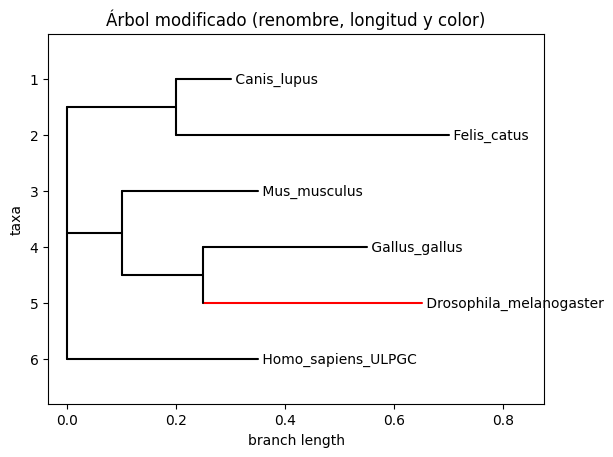

In [29]:


# 1) Renombrar un terminal
for t in tree.get_terminals():
    if t.name == "Homo_sapiens":
        t.name = "Homo_sapiens_ULPGC"

# 2) Cambiar la longitud de rama de una especie
for t in tree.get_terminals():
    if t.name == "Felis_catus":
        t.branch_length = 0.5

# 3) Colorear una rama en rojo (por ejemplo Drosophila)
for t in tree.get_terminals():
    if t.name == "Drosophila_melanogaster":
        t.color = "red"  # Usamos una cadena de color en lugar de Color de Bio.Phylo

# Dibujar el árbol modificado
plt.figure(figsize=(10, 4))
Phylo.draw(tree, do_show=False)
plt.title("Árbol modificado (renombre, longitud y color)")
plt.show()



### Comprobación rápida de que los cambios se aplicaron

Re-listamos terminales y la longitud de la rama de `Felis_catus`.  
También verificamos si `Drosophila_melanogaster` tiene color asignado.


In [30]:

terminals = tree.get_terminals()

print("=== Terminales tras modificar ===")
for t in terminals:
    print(" -", t.name)

print("\n=== Verificación de longitud de Felis_catus ===")
for t in terminals:
    if t.name == "Felis_catus":
        print("Felis_catus branch_length =", t.branch_length)

print("\n=== Verificación de color en Drosophila ===")
for t in terminals:
    if t.name == "Drosophila_melanogaster":
        print("Color asignado:", t.color)


=== Terminales tras modificar ===
 - Canis_lupus
 - Felis_catus
 - Mus_musculus
 - Gallus_gallus
 - Drosophila_melanogaster
 - Homo_sapiens_ULPGC

=== Verificación de longitud de Felis_catus ===
Felis_catus branch_length = 0.5

=== Verificación de color en Drosophila ===
Color asignado: (255, 0, 0)



---
## Extra (opcional): guardar el árbol modificado a Newick

Si queremos entregar el resultado o reutilizarlo, es cómodo volver a exportarlo.  
Biopython permite escribir el árbol en formato `newick`.


In [31]:

from pathlib import Path

out_path = Path("arbol_modificado.nwk")
Phylo.write(tree, out_path, "newick")

print("Guardado en:", out_path.resolve())
print("Contenido:")
print(out_path.read_text())


Guardado en: C:\Users\raule\Documents\Universidad\4ºGCID\1 cuatri\BIO\Arboles\Biopython--rboles-filogen-ticos\arbol_modificado.nwk
Contenido:
((Canis_lupus:0.10000,Felis_catus:0.50000):0.20000,(Mus_musculus:0.25000,(Gallus_gallus:0.30000,Drosophila_melanogaster:0.40000):0.15000):0.10000,Homo_sapiens_ULPGC:0.35000):0.00000;




---
## Conclusión

Con `Bio.Phylo` hemos hecho el flujo típico de la práctica:

- **leer** un árbol en Newick,  
- **inspeccionarlo** (terminales, clados internos, longitudes, profundidades),  
- y **modificarlo** para ver cómo cambian etiquetas, métricas y representación.


